# Air Quality Analysis - Correlation

---

In [ ]:
# Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = 'https://s3-student-datasets-bucket.whjr.online/whitehat-ds-datasets/air-quality/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1)

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int64         
 11  Month          9357 non-null   int64         
 12  Day            9357 non-null   int64         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.1+

The description for all the columns containing data for air pollutants, temperature, relative humidity and absolute humidity is provided below.


|Columns|Description|
|-|-|
|PT08.S1(CO)|PT08.S1 (tin oxide) hourly averaged sensor response (nominally $\text{CO}$ targeted)|
|C6H6(GT)|True hourly averaged Benzene concentration in $\frac{\mu g}{m^3}$|
|PT08.S2(NMHC)|PT08.S2 (titania) hourly averaged sensor response (nominally $\text{NMHC}$ targeted)|
|PT08.S3(NOx)|PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_x$ targeted)|
|PT08.S4(NO2)|PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_2$ targeted)|
|PT08.S5(O3) |PT08.S5 (indium oxide) hourly averaged sensor response (nominally $\text{O}_3$ targeted)|
|T|Temperature in Â°C|
|RH|Relative Humidity (%)|
|AH|AH Absolute Humidity|

---

#### Activity 1: Slope of a Straight Line^

To understand the concept of the correlation, you must understand the concept of slope. *The tangent of the angle made by a straight line with $x-$axis in the anti-clockwise (or counter-clockwise) direction is called slope.*

Consider the straight line shown below.

<img src='https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/positive-slope.jpg' width=700>

Here, a straight line intersects with $x-$axis at point $A$ and makes an angle $\theta$ in the anti-clockwise direction as indicated by the arrowhead of the curved red line.

Let $C$ be an arbitrary point on the line from where a perpendicular is dropped on the $x-$axis. The foot of perpendicular is denoted by $B$.

So in the right-angled triangle $ABC$, $\angle CAB = \theta$, $CB$ is the perpendicular and $BA$ is the base.

$$\therefore \tan \theta = \frac{CB}{BA}$$

Hence, the slope of the straight line is $\tan \theta$ where $0^{\circ}
\le \theta < 360^{\circ}$.

The slope of a straight line is **positive** if the angle created by the line with $x-$axis is an acute angle, i.e., $\theta > 0^{\circ}$ and $\theta < 90^{\circ}$.

The slope of a straight line is **zero** if the angle created by the line with $x-$axis is either zero or $180^{\circ}$, i.e., $\theta = 0^{\circ} \text{or} \space \theta = 180^{\circ}$. In other words, the straight line is parallel to $x-$axis as shown in the image below.

<img src='https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/zero-slope.jpg' width=700>

The slope of a straight line is **undefined** if the angle created by the line with $x-$axis, i.e., $\theta = 90^{\circ} \text{or} \space \theta = 270^{\circ}$. In other words, the straight line is perpendicular to $x-$axis as shown in the image below.

<img src='https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/undefined-slope.jpg' width=700>

The slope of a straight line is **negative** if the angle created by the line with $x-$axis is obtuse, i.e., $\theta > 90^{\circ}$ as shown in the image below.

<img src='https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/negative-slope.jpg' width=700>

Here,

$$\tan \theta = \tan (180^{\circ} - \angle OAB)$$
$$\Rightarrow \tan \theta = - \tan (\angle OAB)$$
$$\because \tan (\angle OAB) = \frac{BO}{OA}$$
$$\Rightarrow \tan \theta = - \frac{BO}{OA}$$

Now, we are ready to understand the concept of correlation.

---

#### Activity 2: Correlation^^

In the previous classes, by creating time series plots, bar plots and box plots, we have seen that the air pollutants, temperature, relative & absolute humidity have shown similar or somewhat identical trends. So for the sake of relationship exploration between two sets of values or features, let's create time series plots for the carbon monoxide & ozone columns one more time to carefully observe the trend again.

To create time series plots, let's define a function which returns a `matplotlib` line plot after taking the following inputs:

1. width & height of the plot

2. the two arrays or series

3. colour of the lines in the line plot

4. the label to label the plots


In [ ]:
# S2.1: Define a function that creates a line plot between two series or arrays. It should take the inputs described above.
def lineplot(width, height, x, y, linecolor, label):
  plt.figure(figsize=(width, height))
  plt.plot(x, y, color=linecolor, label=label)
  plt.legend()
  plt.show()

In [ ]:
df.columns

Index(['DateTime', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
       'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Year', 'Month', 'Day',
       'Day Name'],
      dtype='object')

Now let's create a line plot to visualise the monthly median concentration of carbon monoxide and ozone in the year 2005.

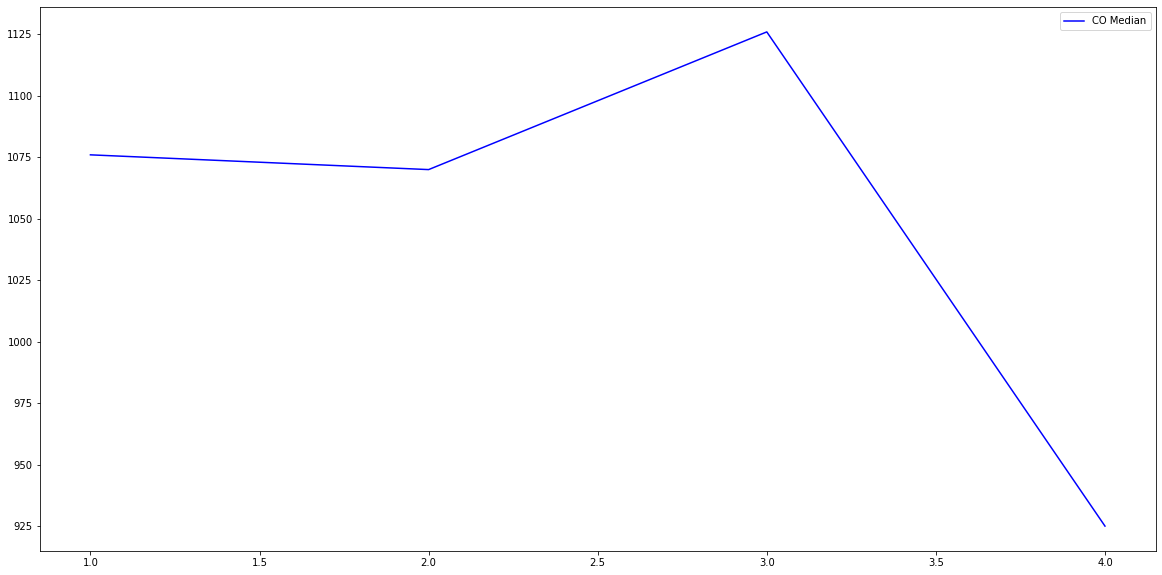

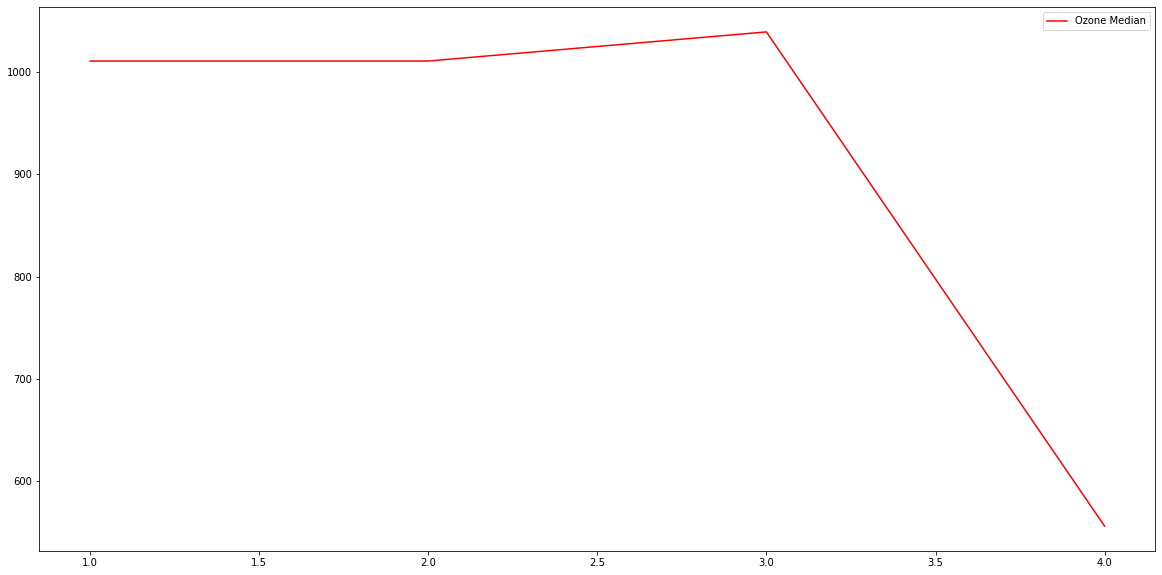

In [ ]:
# S2.2: Create a line plot to visualise the monthly median concentration of carbon monoxide and ozone in the year 2005.
lineplot(20, 10, np.arange(1,5), group_2005_month.median()['PT08.S1(CO)'], 'blue', 'CO Median')
lineplot(20, 10, np.arange(1,5), group_2005_month.median()['PT08.S5(O3)'], 'red', 'Ozone Median')

Look at the lines in the two graphs closely. They follow almost the identical pattern. When the lines for the carbon monoxide graph go up, the lines for the ozone graph also go up and vice-versa. In other words, when the carbon monoxide values increase, the ozone values also increase and vice-versa.

This behaviour suggests a strong linear relationship between the two sets of values.

We can also create a time series plot for these columns, but it would be difficult to identify the pattern because there are too many data-points to plot so the lines in the graphs will be tightly squeezed.

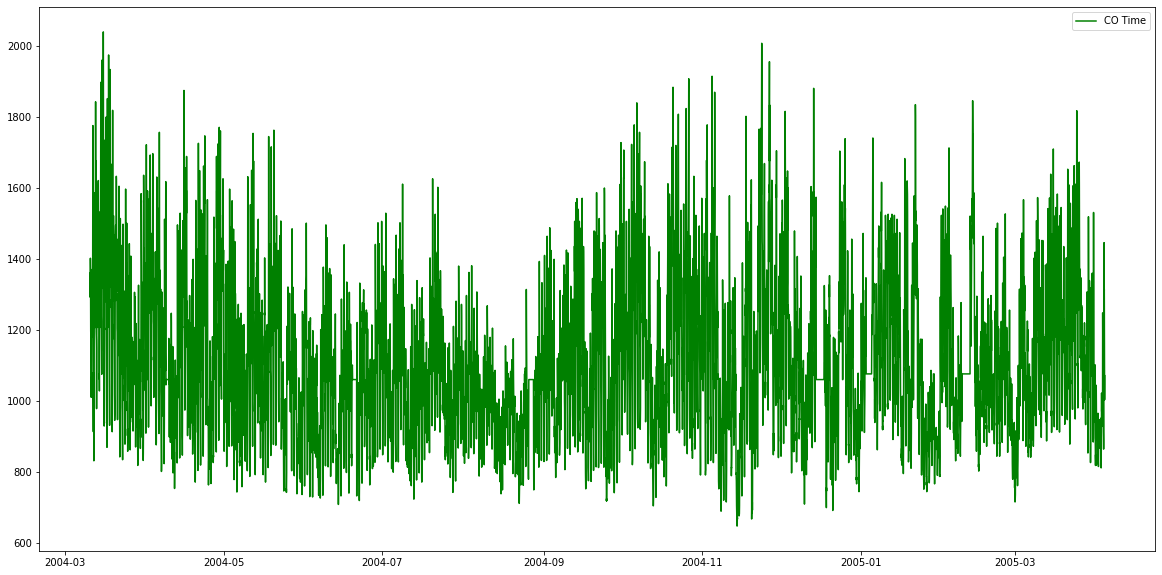

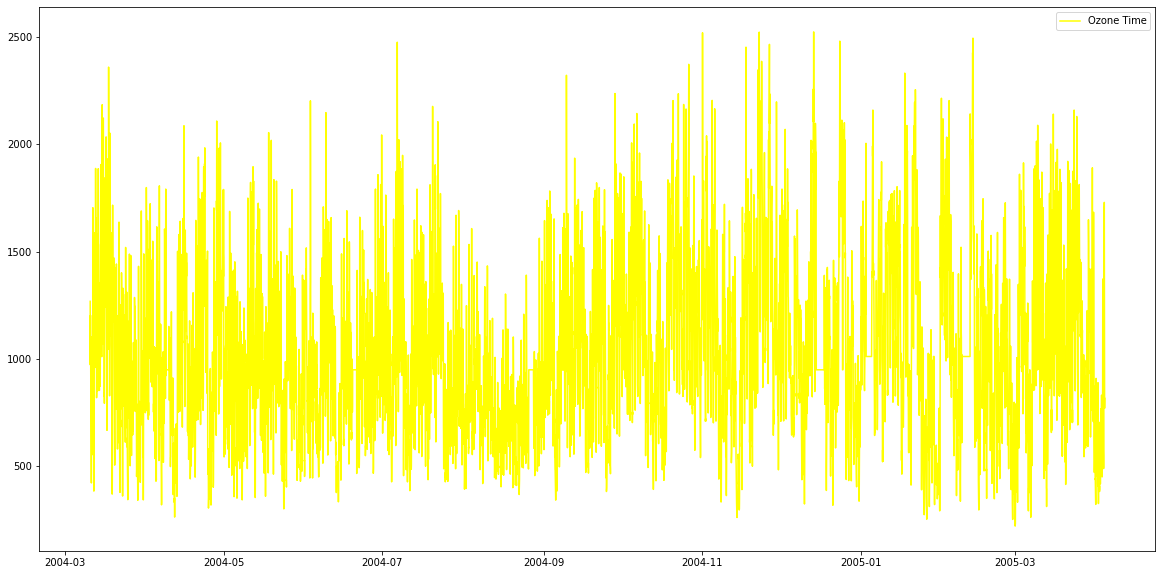

In [ ]:
# S2.3: Create time series plots for the carbon monoxide and ozone columns.
lineplot(20, 10, df['DateTime'], df['PT08.S1(CO)'], 'green', 'CO Time')
lineplot(20, 10, df['DateTime'], df['PT08.S5(O3)'], 'yellow', 'Ozone Time')

Let's create a scatter plot between the carbon monoxide and ozone columns to visualise the variation in their values as the values in one of the columns change.

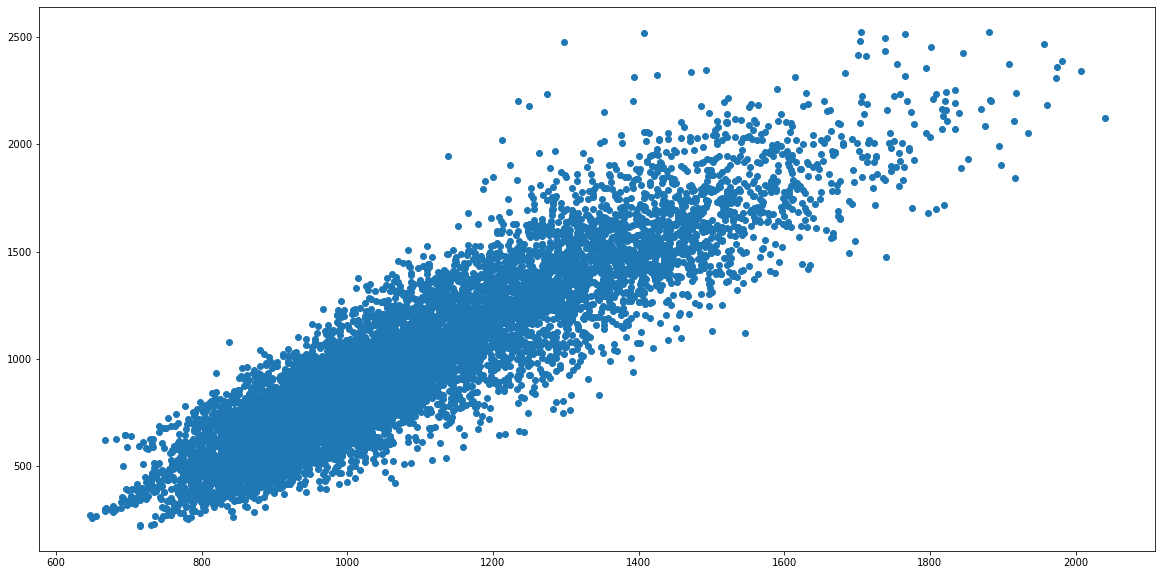

In [ ]:
# S2.4: Create a scatter plot between the carbon monoxide & ozone columns.
plt.figure(figsize=(20, 10))
plt.scatter(df['PT08.S1(CO)'], df['PT08.S5(O3)'])
plt.show()

In the above graph, we can see that as the carbon monoxide values increase, the ozone values also increase and vice-versa. So this behaviour suggests that due to some reason there is some kind of linear relationship between the two features. We don't know that reason but we can measure the strength of this linear relationship.

**The `regplot()` Function**

Assume that we could fit all the points in the above scatter plot with on a straight line. So the straight line will have a positive slope. To create a straight line fitting all the points in the scatter plot use the `regplot()` function of the `seaborn` module.

The straight line that fits all the points in a scatter plot is called a **regression** line which we will cover when we learn linear regression. The regression line doesn't actually pass through all the points in a scatter plot. However, it fits all the points in a way that it is closest to each point in the scatter plot. Again, we will learn this concept in detail when we learn linear regression.

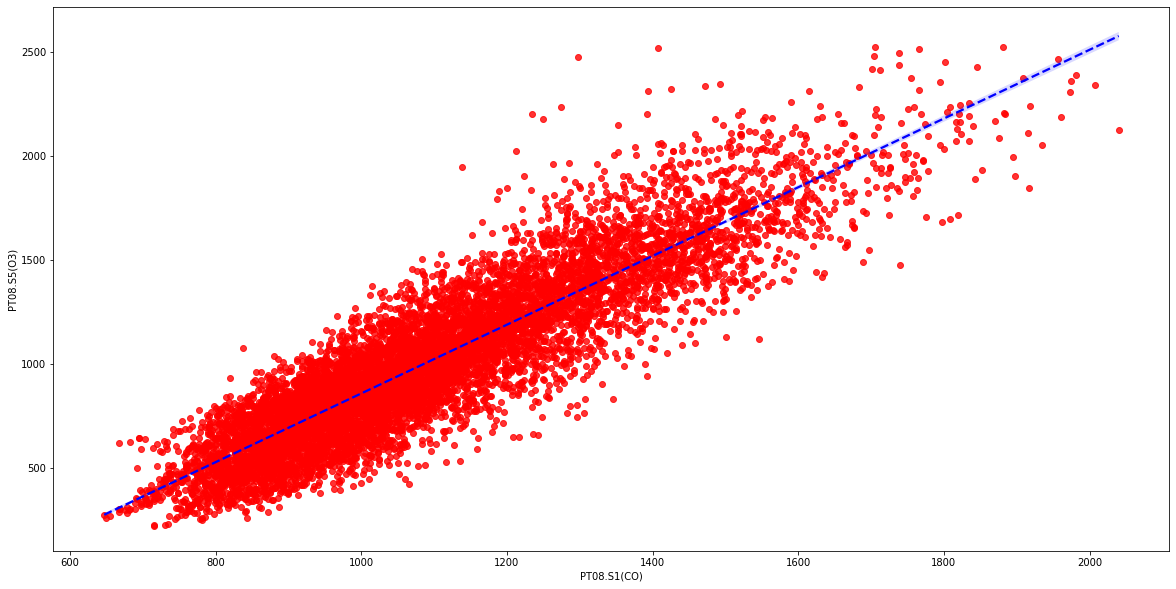

In [ ]:
# T2.1: Create a regression plot for the carbon monoxide and ozone columns.
plt.figure(figsize=(20, 10))
sns.regplot(df['PT08.S1(CO)'], df['PT08.S5(O3)'], color='red', line_kws={'color':'blue', 'linestyle':'--'})
plt.show()

The regression line in the above graph has a positive slope. So this type of linear relationship is called a **positive** linear relationship. Hence, the $R$ value will be positive.

One interesting note, the positive linear relationship between carbon monoxide
and ozone is actually a good sign for us because these two gases may react in the atmosphere to form carbon dioxide and oxygen as shown in the reaction below.

$$CO + O_3 \longrightarrow CO_2 + O_2$$

In fact, many people affected with carbon monoxide poisoning are considered for treatment with ozone. The process of treating a patient having a disease using ozone is called ozone therapy. You can read about ozone therapy more by clicking on the link provided below.

[Ozone Therapy](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3312702/)

The American Journal of Public Health (AJPH) also proposes ozone therapy as a potential treatment for carbon monoxide poisoning which you can read by clicking on the link provided below.

[American Journal of Public Health](https://ajph.aphapublications.org/doi/pdf/10.2105/AJPH.17.3.255)


A relationship between two variables can also be opposite to each other, i.e., as one sets of values increase the other set of values decrease. To get a better understanding,  create a line plot to visualise the monthly median concentration of carbon monoxide and nitrogen oxides in the year 2005 and then create a scatter plot between them.

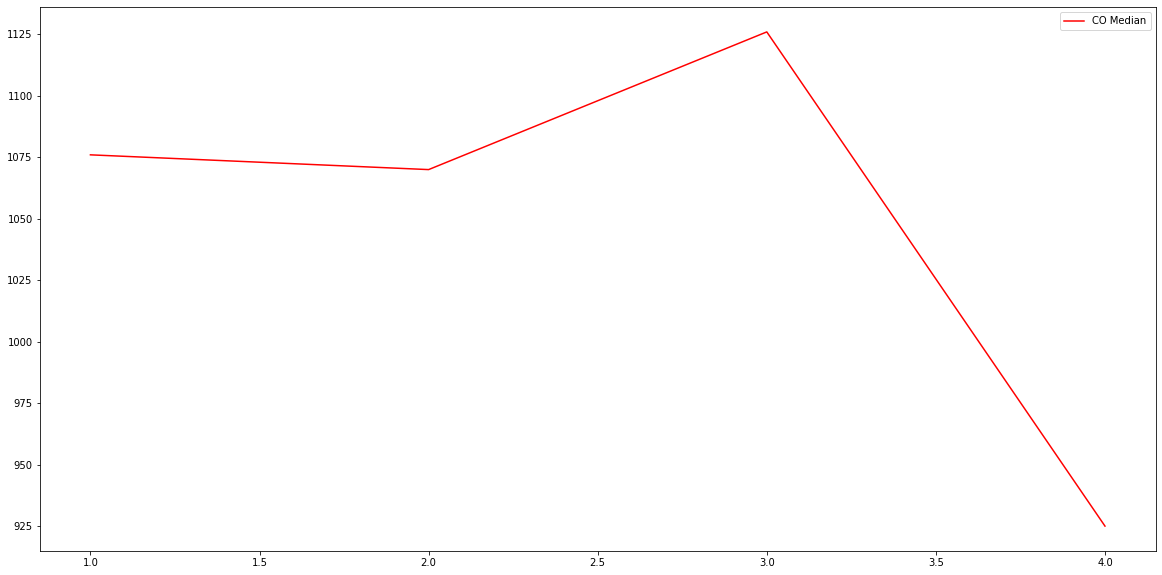

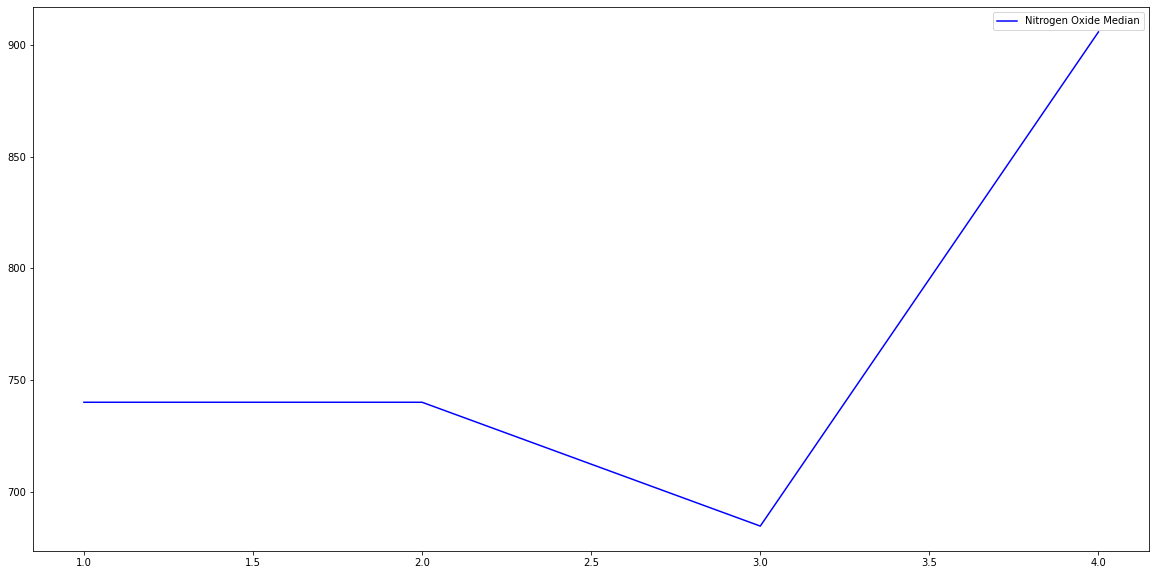

In [ ]:
# S2.5: Create a line plot to visualise the monthly median concentration of carbon monoxide and nitrogen oxides in the year 2005.
lineplot(20, 10, np.arange(1,5), group_2005_month.median()['PT08.S1(CO)'], 'red', 'CO Median')
lineplot(20, 10, np.arange(1,5), group_2005_month.median()['PT08.S3(NOx)'], 'blue', 'Nitrogen Oxide Median')

As the lines for the carbon monoxide time series plot go up, the lines for the nitrogen oxides go down and vice-versa. The two time series graphs are almost mirror images of each other.

Now let's create a scatter plot between the two columns.

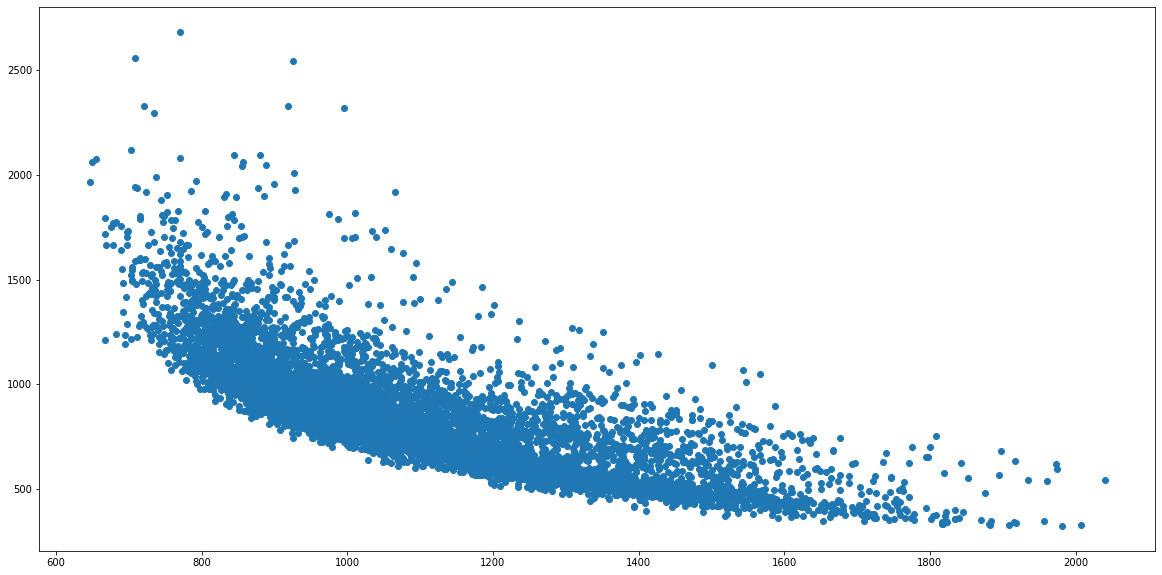

In [ ]:
# S2.6: Create a scatter plot between the carbon monoxide & nitrogen oxides columns.
plt.figure(figsize=(20, 10))
plt.scatter(df['PT08.S1(CO)'], df['PT08.S3(NOx)'])
plt.show()

The above graph suggests that as the values in one column increase, the values in the other column decrease and vice-versa. Again, we don't know the reason behind this relationship but we can measure the strength of this relationship.

Assume that we could represent all the points in the above scatter plot with a straight line. So the straight line will have a negative slope. This type of linear relationship is called a **negative** linear relationship.



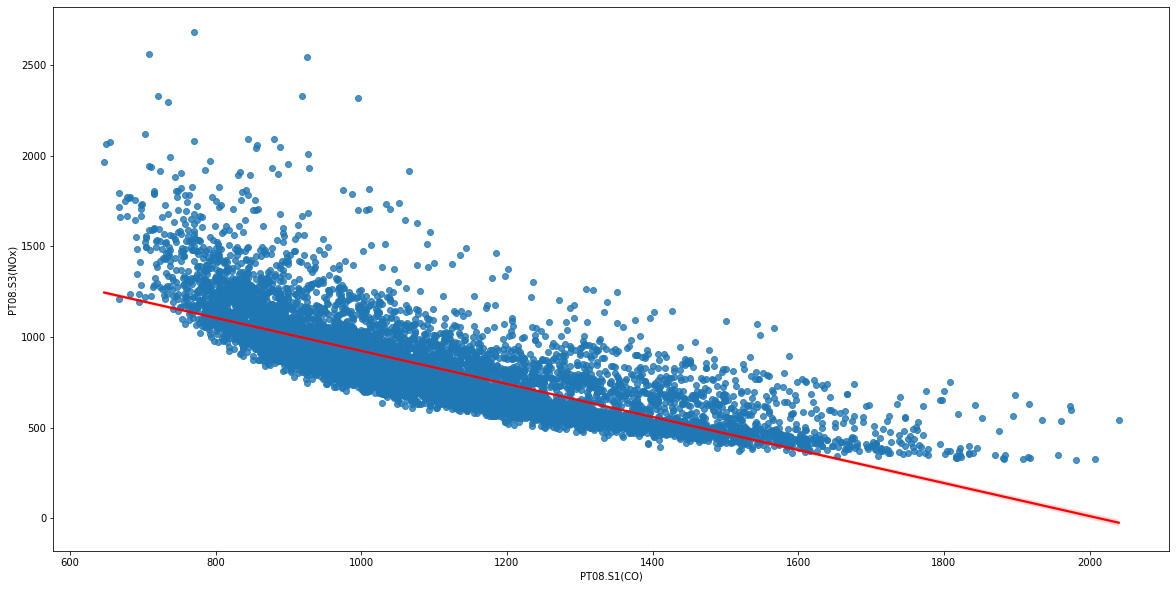

In [ ]:
# S2.7: Create a regression plot for the carbon monoxide and nitrogen oxide columns.
plt.figure(figsize=(20,10))
sns.regplot(df['PT08.S1(CO)'], df['PT08.S3(NOx)'], line_kws={"color":"red"})
plt.show()

The linear relationship (either negative or positive) between two features or sets of values is called **correlation**. Now the question is, how do we calculate the strength of a linear relationship (or correlation). The answer is "by calculating a numeric value called correlation coefficient".

---

#### Activity 3: Correlation Coefficient

A correlation coefficient is a numeric values that range between $-1$ to $1$ including both. It tells us the strength (or degree) of a relationship between two sets of quantities or features. It is denoted by letter $R$.

- If $R > 0$, the two sets of values exhibit a **positive** linear relationship.

- If $R = 0$, the two sets of values exhibit a **no** linear relationship.

- If $R < 0$, the two sets of values exhibit a **negative** linear relationship.

To calculate the value of the correlation coefficient between two sets of values, use the `corrcoef()` function of the `numpy` module.

**Syntax:** `np.corrcoef(array1, array2)` where `np` denotes alias for the `numpy` module and `array1` & `array2` are the two sets of values for which the correlation coefficient value needs to be calculated.

The `corrcoef()` function returns a two-dimensional array.

- The first row & first column contains the correlation coefficient (or $R$) value for the correlation between `array1` and `array1` which will always be 1.

- The first row & second column contains the $R$ value for the correlation between `array1` and `array2` .

- The second row & first column contains the $R$ value for the correlation between `array2` and `array1`.

- The second row & second column contains the $R$ value for the correlation between `array2` and `array2` which will always be 1.

Let's calculate the correlation coefficient for the carbon monoxide & ozone columns.

In [ ]:
# S3.1: Calculate the correlation coefficient for the carbon monoxide & ozone columns.
np.corrcoef(df['PT08.S1(CO)'], df['PT08.S5(O3)'])

array([[1.        , 0.89936876],
       [0.89936876, 1.        ]])

The correlation between carbon monoxide and ozone columns is `0.90`.

Now let's calculate the correlation coefficient for the correlation between carbon monoxide & nitrogen oxides columns.


In [ ]:
# S3.2: Calculate the correlation coefficient for the correlation between carbon monoxide & nitrogen oxides columns.
np.corrcoef(df['PT08.S1(CO)'], df['PT08.S3(NOx)'])

array([[ 1.        , -0.76992041],
       [-0.76992041,  1.        ]])

So, the correlation coefficient for the correlation between the carbon monoxide and nitrogen oxides columns is `-0.77`

**The `corr()` Function**

What if we want to calculate the correlation coefficient values between all the columns (taking two columns at a time) at once?

To calculate the correlation coefficient between all the numeric columns in a DataFrame, use the `corr()` function of the `pandas` module. It returns an N-dimensional DataFrame containing the correlation coefficient values between the numeric columns.

In [ ]:
# S3.3: Calculate the R value between all the air pollutants, temperature, relative & absolute humidity columns in the 'df' DataFrame.
df.iloc[:, 0:-3].corr()

PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  PT08.S3(NOx)  \
PT08.S1(CO)       1.000000  0.882921       0.892097     -0.769920   
C6H6(GT)          0.882921  1.000000       0.981707     -0.730267   
PT08.S2(NMHC)     0.892097  0.981707       1.000000     -0.792370   
PT08.S3(NOx)     -0.769920 -0.730267      -0.792370      1.000000   
PT08.S4(NO2)      0.677392  0.764243       0.775995     -0.528111   
PT08.S5(O3)       0.899369  0.864326       0.879285     -0.795013   
T                 0.048765  0.203647       0.245397     -0.138125   
RH                0.114426 -0.062666      -0.091310     -0.057582   
AH                0.134961  0.172959       0.191374     -0.224756   
Year              0.024821 -0.140098      -0.153476     -0.151616   

               PT08.S4(NO2)  PT08.S5(O3)         T        RH        AH  \
PT08.S1(CO)        0.677392     0.899369  0.048765  0.114426  0.134961   
C6H6(GT)           0.764243     0.864326  0.203647 -0.062666  0.172959   
PT08.S2(NMHC)      0.775995     0.879285  0.245397 -0.091310  0.191374   
PT08.S3(NOx)      -0.528111    -0.795013 -0.138125 -0.057582 -0.224756   
PT08.S4(NO2)       1.000000     0.585281  0.568770 -0.034751  0.635471   
PT08.S5(O3)        0.585281     1.000000 -0.027593  0.124988  0.069730   
T                  0.568770    -0.027593  1.000000 -0.576271  0.661982   
RH                -0.034751     0.124988 -0.576271  1.000000  0.163933   
AH                 0.635471     0.069730  0.661982  0.163933  1.000000   
Year              -0.510821     0.045971 -0.532344  0.104650 -0.521380   

                   Year  
PT08.S1(CO)    0.024821  
C6H6(GT)      -0.140098  
PT08.S2(NMHC) -0.153476  
PT08.S3(NOx)  -0.151616  
PT08.S4(NO2)  -0.510821  
PT08.S5(O3)    0.045971  
T             -0.532344  
RH             0.104650  
AH            -0.521380  
Year           1.000000

The `df` DataFrame contains few numeric columns so it is easier to pinpoint the columns exhibiting high correlation. But what if there are little more columns?

**The `heatmap()` Function**

To easily pinpoint the columns exhibiting high correlation, you can create a heatmap using the `heatmap()` function of the `seaborn` module.

It takes the DataFrame containing the correlation coefficient values as an input and returns an N-dimensional heat map in which each cells are represented through colour densities.

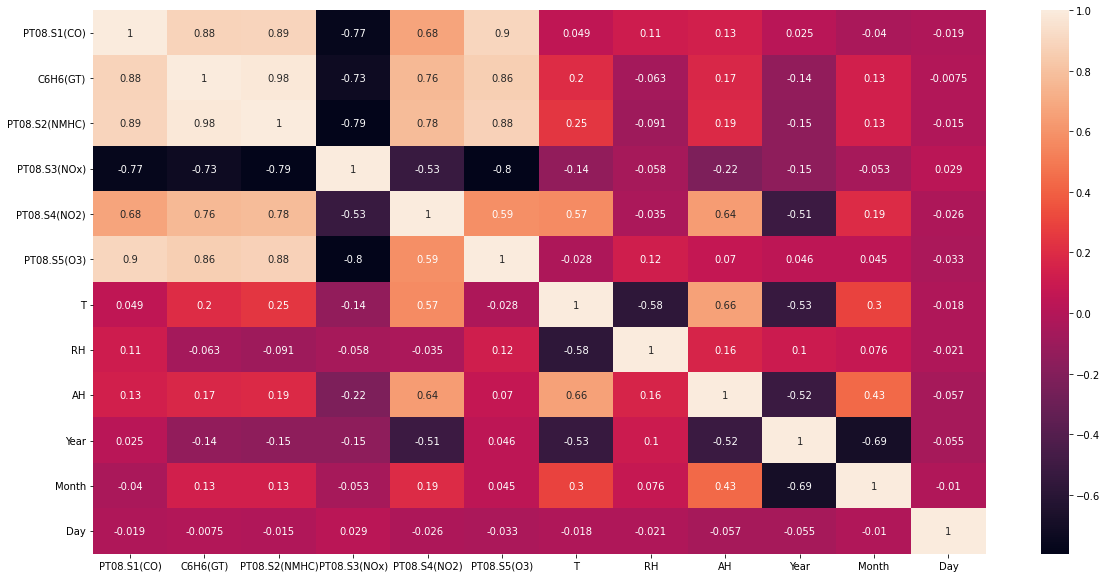

In [ ]:
# T3.1: Create a heatmap to pinpoint the columns in the 'df' DataFrame exhibiting high correlation.
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In the above heatmap, the cells having lighter colour densities denote greatest positive correlation between two columns and the cells having darker colour densities denote greatest negative correlation between two columns.

You can change the colour scheme of a heatmap by specifying another colour scheme using the `cmap` parameter.

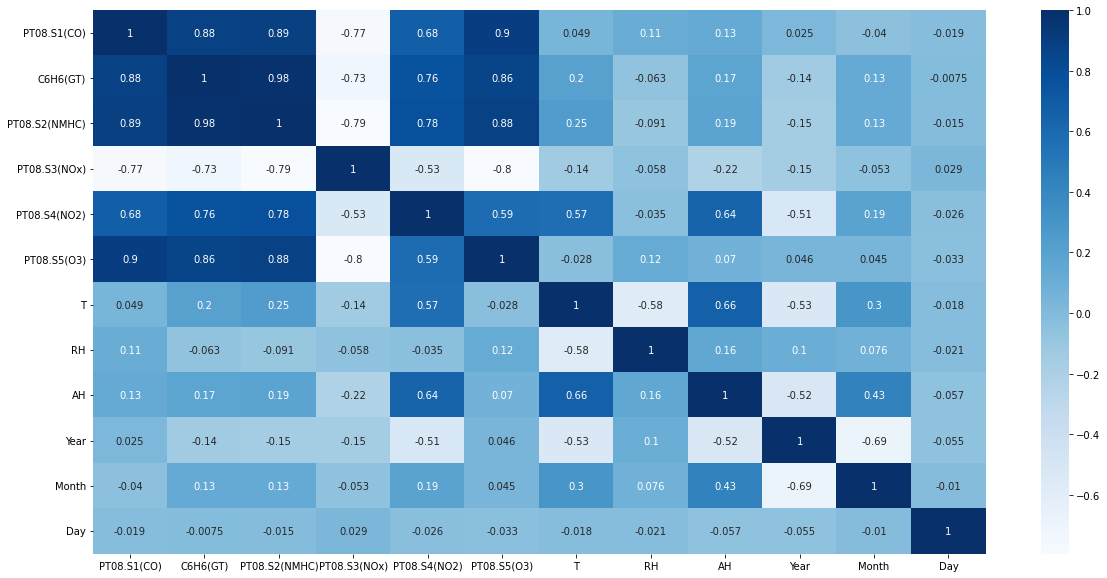

In [ ]:
# S3.4: Change the colour scheme of the cells of the above heatmap to 'yellow-green-blue' by passing the 'YlGnBu' value to the 'cmap' parameter.
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show()

In the above heatmap, this time, the cells having darker colour densities denote greatest positive correlation between two columns and the cells having lighter colour densities denote greatest negative correlation between two columns.


**The `pairplot()` Function**

You can also create a scatter plot between all the features (taking two features at a time) in one go by using the `pairplot()` function of the `seaborn` module. It takes the DataFrame containing numeric values and returns all the scatter plots in the form of an $N$-dimensional array for all the possible combinations of the features (taking two features at a time).

**Note:** The `pairplot()` function is a computationally heavy function so it may take some time to return the required scatter plots.

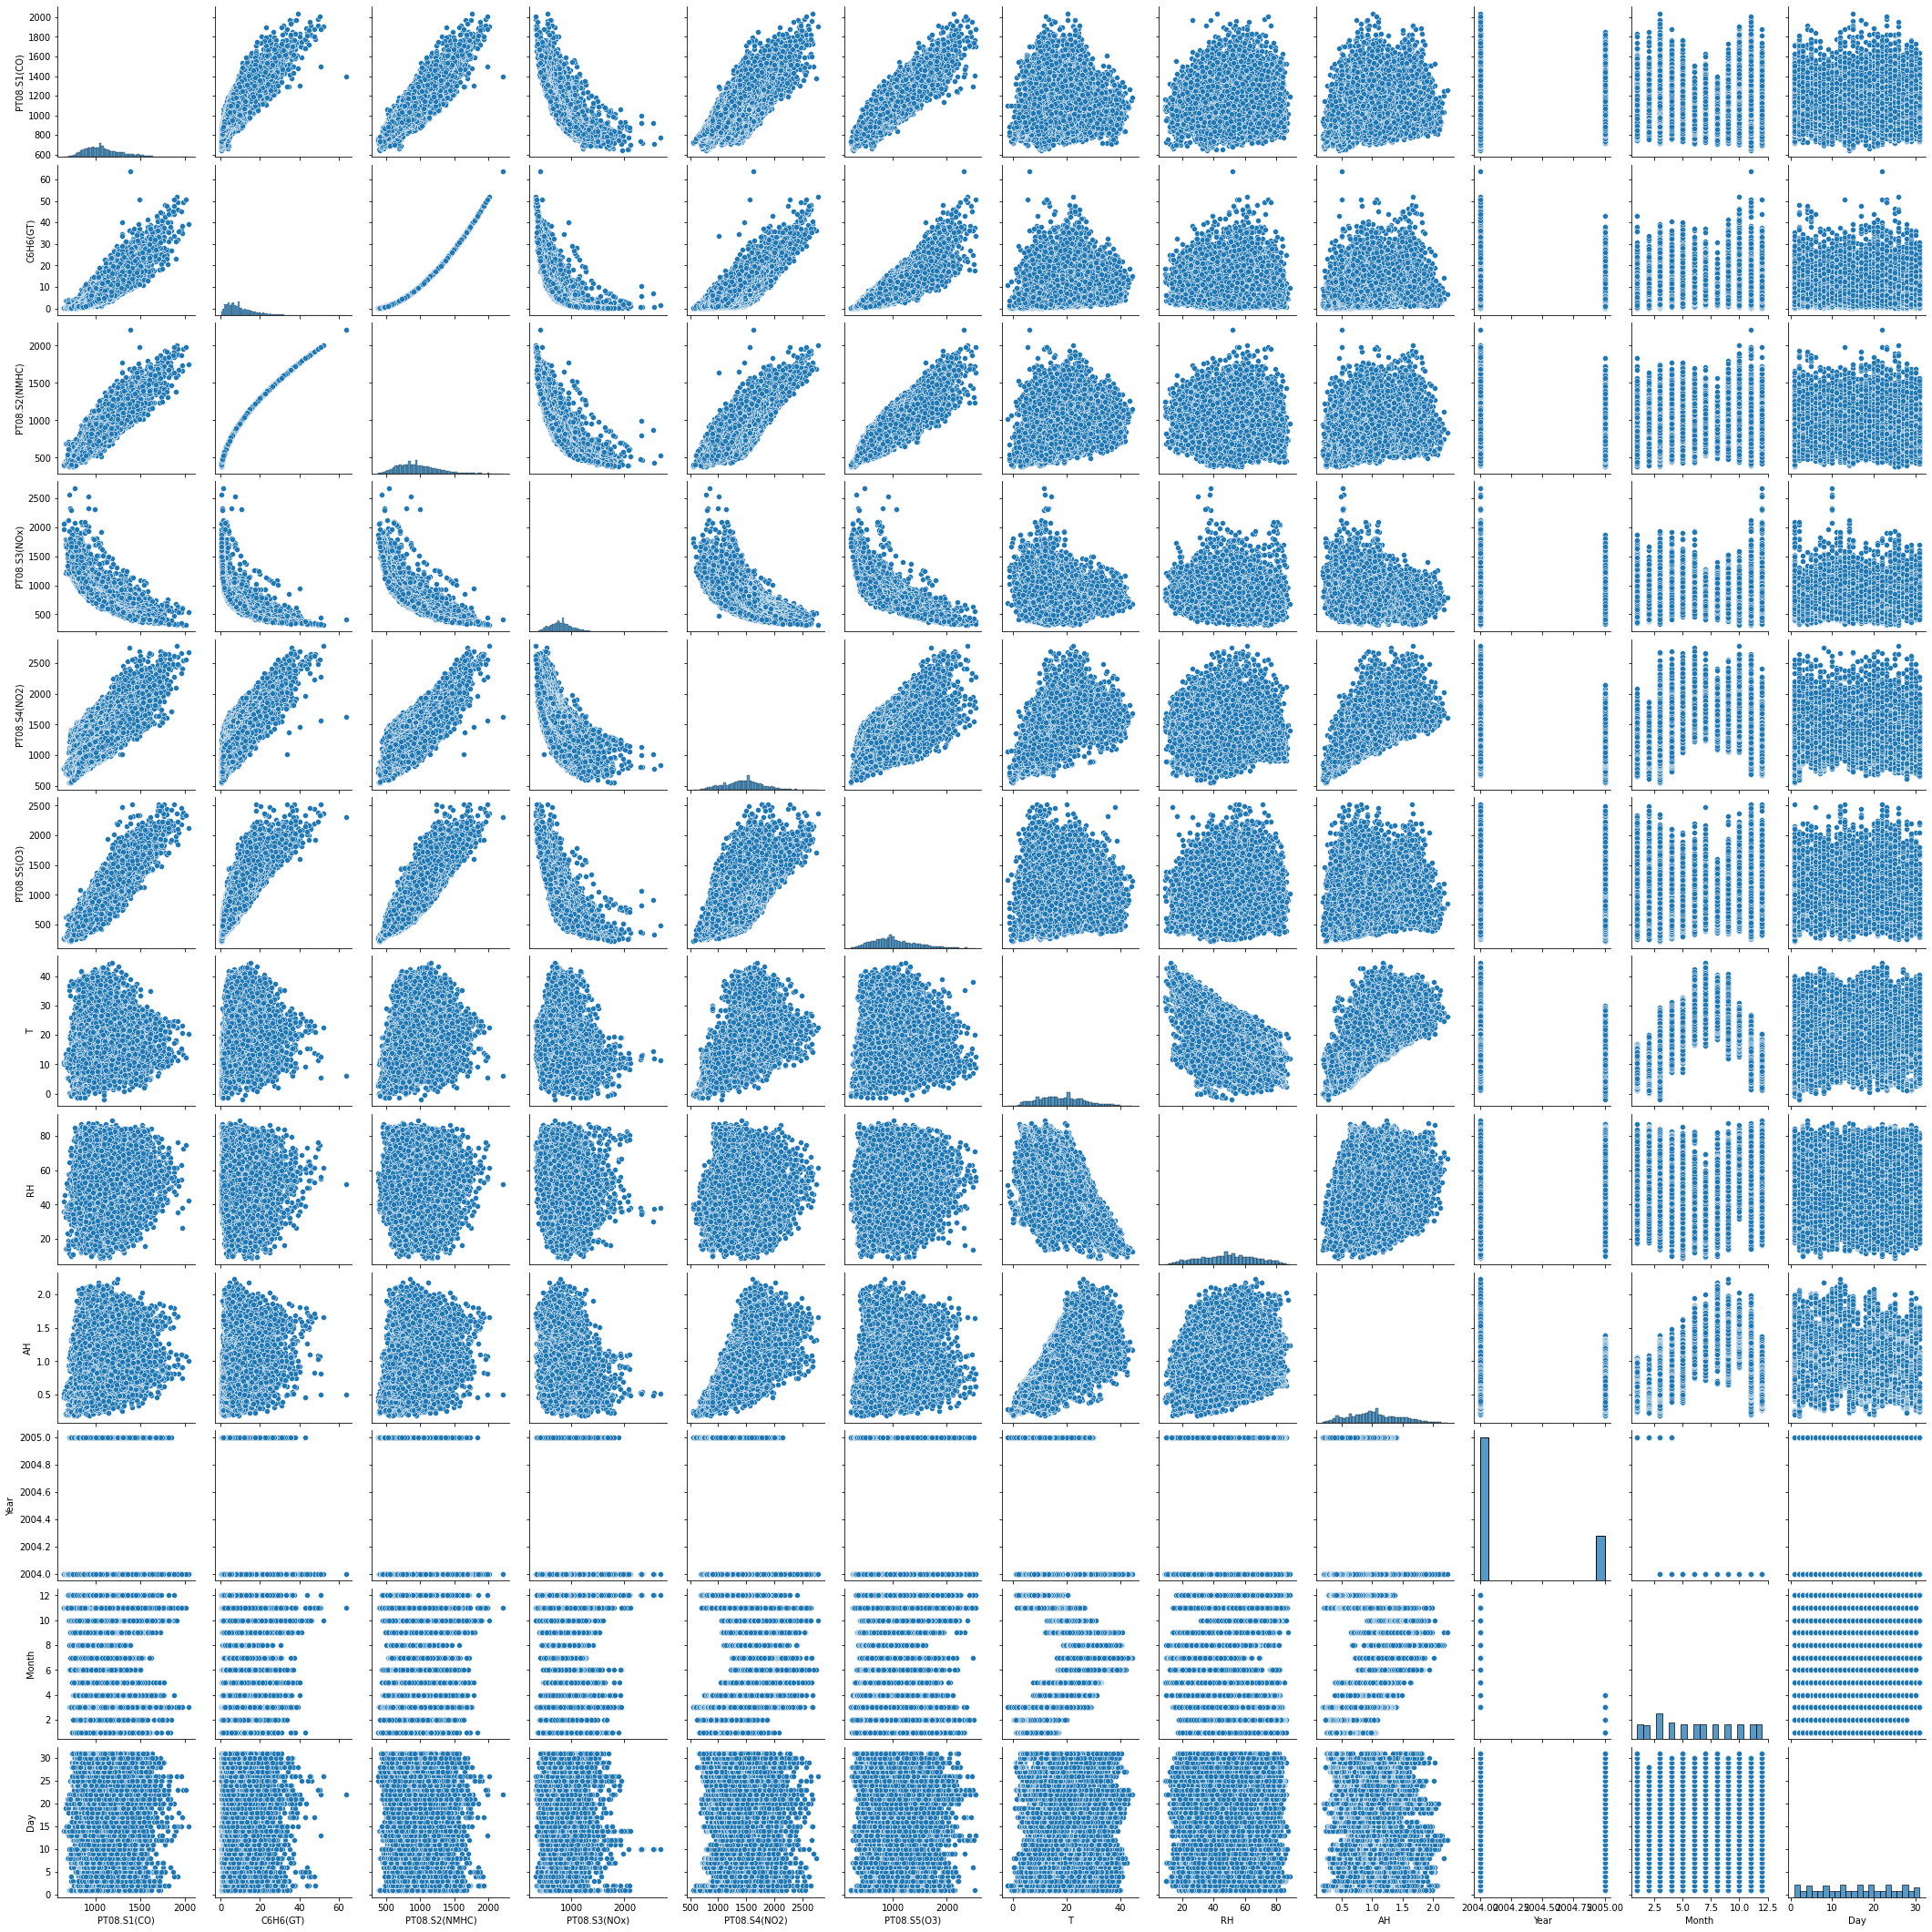

In [ ]:
# S3.5: Create the scatter plots for the numeric columns of the 'df' DataFrame in one go.
sns.pairplot(df)
plt.show()

Look at the scatter plot between NMHC (Non-Methane Hydrocarbons) and $\text{C}_6 \text{H}_6$ (Benzene). They have a perfectly smooth curve which tells us that as the concentration of NMHC increases, the concentration of benzene also increases. This makes a lot of sense because benzene is a non-methane hydrocarbon. It does not contain a methane group either in its structure.

---

#### Activity 4: Important Points On Correlation

1. Correlation coefficient only measures the strength of a linear relationship. It doesn't mean that an increase/decrease in one set of values causes an increase/decrease in another set of values. The linear relationship between them could be an outcome of pure luck. Hence, correlation doesn't mean causation even if the two sets of values form a perfect straight line. In the case of a perfect straight line, it only means that there is a very very low probability that the linear relationship is out of pure luck.

2. The correlation coefficient value is significant only if there are lots of data points (preferably at least in thousand). Otherwise, it is insignificant. E.g., two points on a coordinate-axes will always form a straight line because two points are always collinear. The correlation coefficient will always be either $1$ or $-1$ for a set of values containing only two data points.


3. The correlation coefficient value should only be used for making best guesses. E.g., if the carbon monoxide value is 1200 units, then there is a high probability that the nitrogen oxides value would be somewhere between 700 and 1000 units.

4. Strength of correlation in most of the cases

   - If $R \ge 0.7$ or $R \le -0.7$, then there is a strong correlation.

   - If $0.5 \le R < 0.7$ or $-0.7 < R \le -0.5$, then there is a moderate correlation.

   - In other cases, there is a weak correlation. These ranges for correlation coefficient are just guidelines, not rules. Hence, these can be altered according to the problem statements.

---

#### Activity 5: More on Scatter Plots^^^

You can also use the `scatterplot()` function of the `seaborn` module to create a scatter plot.

Let's create a scatter plot between the temperature and absolute humidity columns using the `scatterplot()` function of the `seaborn`.

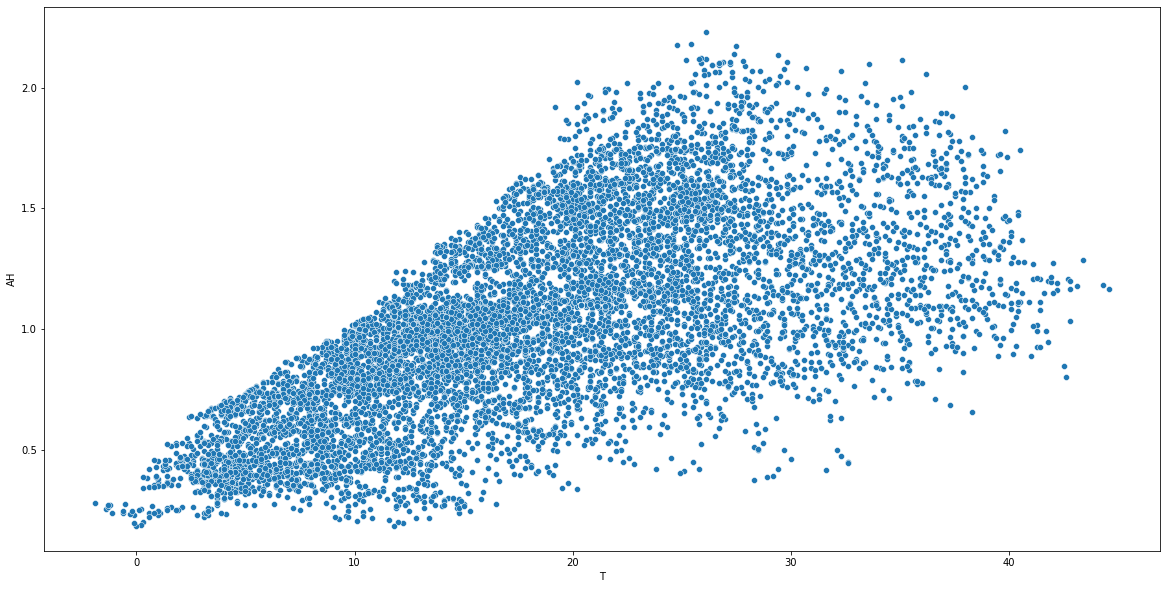

In [ ]:
# S5.1: Create a scatter plot between the temperature and absolute humidity columns using the scatterplot() function of the 'seaborn' module.
plt.figure(figsize=(20,10))
sns.scatterplot(x='T', y='AH', data=df)
plt.show()

We can see that the temperature and absolute humidity also have a positive correlation.


You can differentiate between the points for the year 2004 and 2005 by passing the `Year` column as an input to the `hue` parameter.

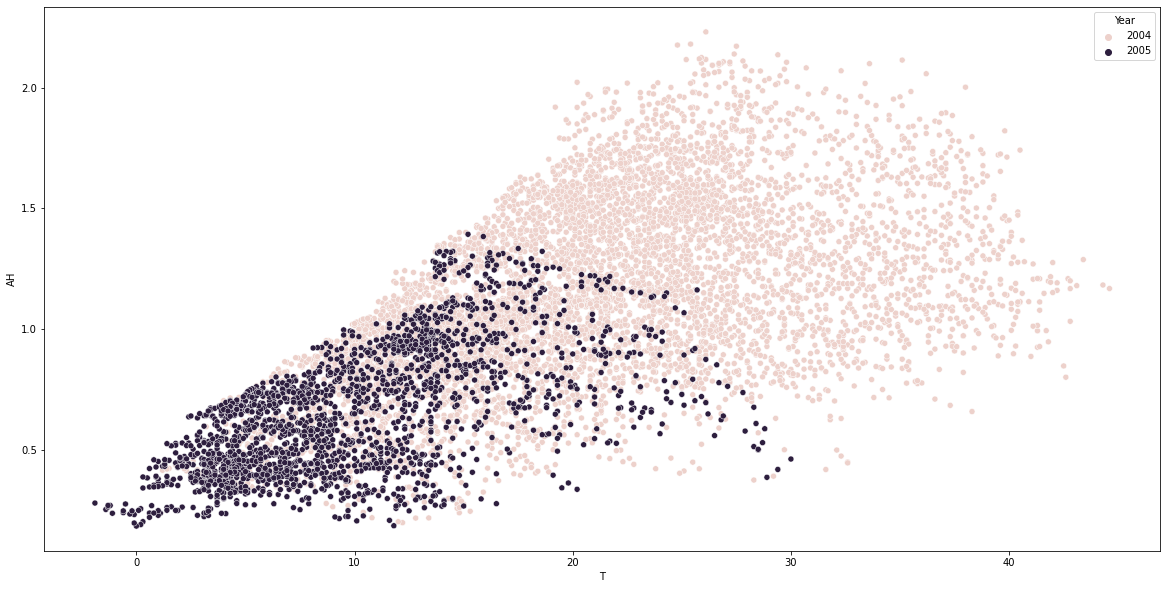

In [ ]:
# S5.2: Differentiate between the points for the year 2004 and 2005 values in the above scatter plot.
plt.figure(figsize=(20,10))
sns.scatterplot(x='T', y='AH', data=df, hue='Year')
plt.show()

You can also create a scatter plot between two sets of values by using the `jointplot()` function of the seaborn module.

**Syntax:** `sns.jointplot(x=col1, y=col2, data=data_frame, kind='scatter')` where `col1` and `col2` are two columns of the `data_frame` and `kind` parameter defines the kind of joint plot to be created between the two columns. Here, we want to create the `scatter` plot so we will pass the `scatter` value to the `kind` parameter.

**Note:** The `jointplot()` function will also return a histogram for `col1` on top of the joint plot and a histogram for `col2` on the right-hand side of the joint plot.

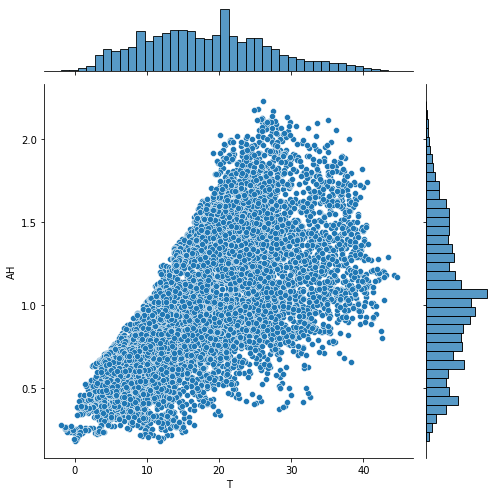

In [ ]:
# S5.3: Create a scatter plot between the the temperature and absolute humidity using the jointplot() function
sns.jointplot(x='T', y='AH', data=df, kind='scatter', height=7)
plt.show()

On top of the joint plot, there is a histogram for the temperature column. Similarly, on the right-hand side of the joint plot, there is a histogram for the absolute humidity columns.


The `jointplot()` function always returns a joint plot in the square shape, i.e., the width and height of a plot are always the same.

To resize a joint plot, you will have to pass a numeric value to the `height` parameter inside the `jointplot()` function. You can additionally specify the colour of a joint plot using the `color` parameter.

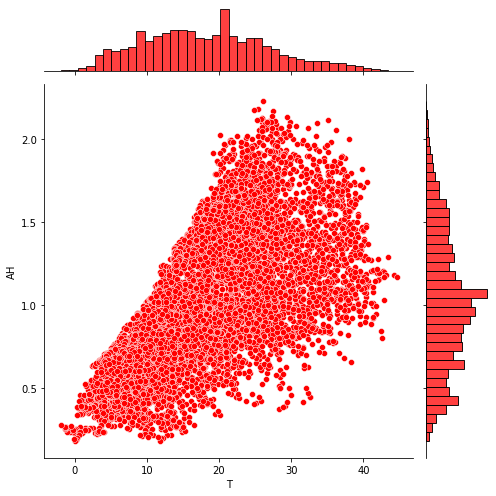

In [ ]:
# S5.4: Resize the above joint plot and change its colour.
sns.jointplot(x='T', y='AH', data=df, kind='scatter', height=7, color='red')
plt.show()